# Импорт модулей

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Функция для конвертации из бинарного формата в csv формат
Функция convert конвертирует входные файлы для данных (train-images-idx3-ubyte-32x32), и для меток (train-labels.idx1-ubyte) в csv формат с которым будет удобно работать. В первый столбец сохраняются метки данные сохраняются последовательно в следующие столбцы

In [2]:
def convert(imgf, labelf, outf, n):
    f = open(imgf, "rb")
    o = open(outf, "w")
    l = open(labelf, "rb")

    f.read(16)
    l.read(8)
    images = []

    for i in range(n):
        image = [ord(l.read(1))]
        for j in range(32*32):
            image.append(ord(f.read(1)))
        images.append(image)

    for image in images:
        o.write(",".join(str(pix) for pix in image)+"\n")
    f.close()
    o.close()
    l.close()

convert("/content/drive/MyDrive/2/Classes (simple)/10000/train-images-idx3-ubyte-32x32/train-images-idx3-ubyte-32x32", 
        "/content/drive/MyDrive/2/Classes (simple)/10000/train-labels-idx1-ubyte/train-labels.idx1-ubyte",
        "/content/drive/MyDrive/2/Classes (simple)/10000/train.csv", 10000)

# Считываем файл данных 
В переменную df считываем файл (train.csv) задаем для него названия колонок (col_name). В переменную label добавляем первый столбец файла train.csv, удаляя его из df.


In [3]:
col_name = ['label'] + list(range(0, 1024))
df = pd.read_csv('/content/drive/MyDrive/2/Classes (simple)/10000/train.csv', header=None, names=col_name)
label = df['label'].copy().to_numpy()
df.drop(['label'], axis=1, inplace=True)

In [4]:
def scale_mnist_data(train_images, test_images):
    """
    Эта функция принимает тренировочные и тестовые изображения, и масштабирует их.
    так, чтобы они имели минимальное и максимальное значения, равные 0 и 1 соответственно.
    """
    train_images = train_images / 255
    test_images = test_images / 255

    return train_images, test_images

# Функция в которой задаем архитектуру модели с помощью метода tf.keras.Sequential

Архитектура модели:

1) Сверточный слой Conv2D принимает количество фильтров, размер фильтра 3 на 3, 
padding='SAME' значает, что когда картинка передасться в следующий слой размер картинки не изменится, функция активации relu, и входной размер картинки

2) Слой пулинга MaxPooling2D передаем размер фильтра 2 на 2, уменьшает размер катринки в 2 раза

3) Flatten нужен, что бы выход последнего слоя пулинга превратить в массив с одним измерением.

4) Dense полносвязные слои нейронов, передаем количество нейронов, функция активации relu для двух предпоследних слоев. Функция активации softmax для последнего слоя и 10 нейронов так как значений предсказываемой перенной тоже 10.
Функция softmax выдает верояность принадлежности к классу.

In [5]:
def get_model(input_shape):
    """
    Функция должна построить последовательную модель
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(8, (3, 3), padding='SAME', activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    return model

# Функция компиляции  модели

Оптимизатор tf.keras.optimizers.Adam() метод для нахождения градиентов

Функция потерь sparse_categorical_crossentropy, так как мы не преобразуем классы с помощью one hot encoding то будем использовать данную функцию потерь

Метрика качества accuracy, описывает общую точность предсказания модели по всем классам.


In [6]:
def compile_model(model):
    """
    Функция принимает модель, возвращенную функцией get_model, и компилирует ее с помощью оптимизатора.
    """

    opt = tf.keras.optimizers.Adam()

    model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=["accuracy"])

In [7]:
def train_model(model, scaled_train_images, train_labels, validation_set):
    """
    Эта функция должна обучать модель в течение 5 эпох на scaled_train_images и train_labels.
    Функция должна возвращать историю обучения, возвращаемую model.fit.
    """

    history = model.fit(scaled_train_images, train_labels, epochs=20, batch_size=256, validation_data=validation_set)

    return history

# Разделим данные на тренировачные и тестовые

В переменную array_mnist из df добавим все данные предварительно превратив df в массив numpy и поменяв размерность данных на (10000, 32, 32). Получается 10000 картинок размерностью 32 на 32 пикселя

Разделим данные на тренировачные и тестовые с помощью функции train_test_split, размер тестовых данных составит 25 процентов от общего количества данных

In [8]:
array_mnist = df.copy().to_numpy().reshape((10000, 32, 32))
train_images, test_images, train_labels,  test_labels = train_test_split(array_mnist, label, test_size=0.25)

# Обработка данных

С помощью функции scale_mnist_data отмаштабируем тренировачные и тестовые данные. Далее добавим к данным дополнительную размерность 

In [9]:
scaled_train_images, scaled_test_images = scale_mnist_data(train_images, test_images)
scaled_train_images = scaled_train_images[..., np.newaxis]
scaled_test_images = scaled_test_images[..., np.newaxis]
scaled_test_images.shape

(2500, 32, 32, 1)

# Создание модели и компиляция модели

С помощью функции get_model создаим архитектуру модели передав в нее размеры входных данных

С помощью функции compile_model скомпилируем модель

In [10]:
model = get_model(scaled_train_images[0].shape)
model.summary()
compile_model(model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 8)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                        

# Обучаем модель

В перемнную history сохранится информация о значениях функции потерь, метрики качества для каждой эпохи обучения.

Добавим историю обучения в фрейм данных frame

In [11]:
VALIDATION_SET = (scaled_test_images, test_labels)

history = train_model(model, scaled_train_images, train_labels, VALIDATION_SET)

Epoch 1/20
30/30 [==============================] - 3s 14ms/step - loss: 1.7029 - accuracy: 0.5873 - val_loss: 0.8269 - val_accuracy: 0.8192
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.5280 - accuracy: 0.8580 - val_loss: 0.3879 - val_accuracy: 0.8968
Epoch 3/20
30/30 [==============================] - 0s 6ms/step - loss: 0.3380 - accuracy: 0.9000 - val_loss: 0.3107 - val_accuracy: 0.9152
Epoch 4/20
30/30 [==============================] - 0s 6ms/step - loss: 0.2720 - accuracy: 0.9203 - val_loss: 0.2711 - val_accuracy: 0.9248
Epoch 5/20
30/30 [==============================] - 0s 6ms/step - loss: 0.2370 - accuracy: 0.9297 - val_loss: 0.2589 - val_accuracy: 0.9276
Epoch 6/20
30/30 [==============================] - 0s 6ms/step - loss: 0.2048 - accuracy: 0.9392 - val_loss: 0.2263 - val_accuracy: 0.9352
Epoch 7/20
30/30 [==============================] - 0s 6ms/step - loss: 0.1791 - accuracy: 0.9484 - val_loss: 0.2077 - val_accuracy: 0.9400
Epoch 8/20
30/30 [=

# Визуализируем функцию потерь и accuracy 
Добавим историю обучения в фрейм данных frame

In [17]:
frame.head()

,loss,accuracy,val_loss,val_accuracy
0,1.702854,0.587333,0.826867,0.8192
1,0.528044,0.858000,0.387909,0.8968
2,0.338009,0.900000,0.310743,0.9152
3,0.271986,0.920267,0.271094,0.9248
4,0.237028,0.929733,0.258915,0.9276


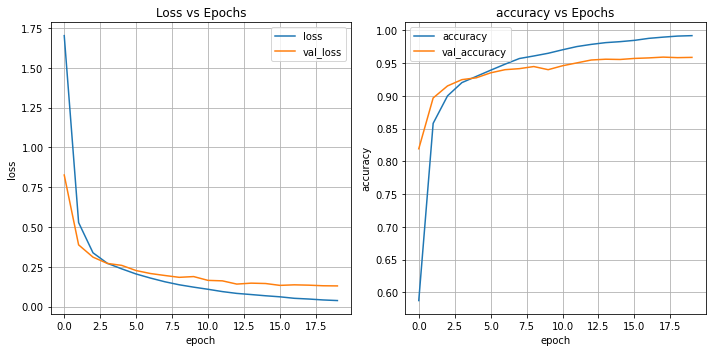

In [20]:
frame = pd.DataFrame(history.history)

fig, ax=plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
frame['loss'].plot(title="Loss vs Epochs",  ax=ax[0], grid= True, legend=True)
frame['accuracy'].plot(ax=ax[1], title="accuracy vs Epochs", grid= True, legend=True)
frame['val_loss'].plot(title="Loss vs Epochs",  ax=ax[0], grid= True, legend=True)
frame['val_accuracy'].plot(ax=ax[1], title="accuracy vs Epochs", grid= True, legend=True)
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
plt.tight_layout()
plt.show()

# Тестируем модель

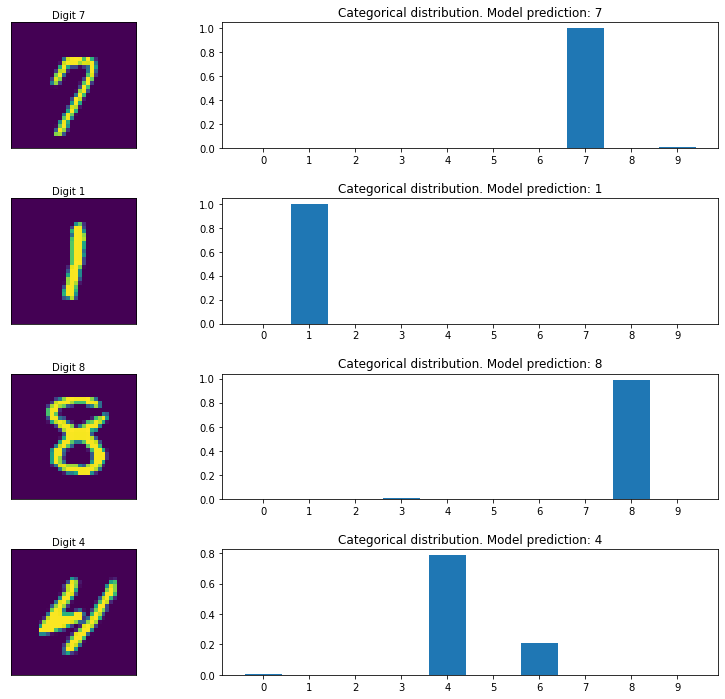

In [13]:
random_inx = np.random.choice(scaled_test_images.shape[0], 4)
random_test_images = scaled_test_images[random_inx, ...]
random_test_labels = test_labels[random_inx, ...]

predictions = model.predict(random_test_images)

fig, axes = plt.subplots(4, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title(f"Categorical distribution. Model prediction: {np.argmax(prediction)}")

plt.show()